Hough-Transformation

2. Implementieren Sie die Hough-Transformation f ̈ur Geraden. Verwenden Sie die Hesse’sche
Normalform (HNF) und orientieren Sie sich bez ̈uglich des Programmieransatzes an die
Vorlesungsunterlagen (bzw. Buch Seite 162). Wenden Sie die Hough-Transformation
auf das Bild noisy-lines an.
•Prototyp: houghArray = linearHT(im edge, angle steps, angle steps)
houghArray: Ergebnisbild nach Hough-Transformation (int)
im edge: Eingangsbild in Bin ̈arform (0,1)
angle stepsize: Schrittweite Winkel (int)
radius stepsize: Schrittweite Radius (int)
Beispielaufruf: linearHT(image, 100, 100);

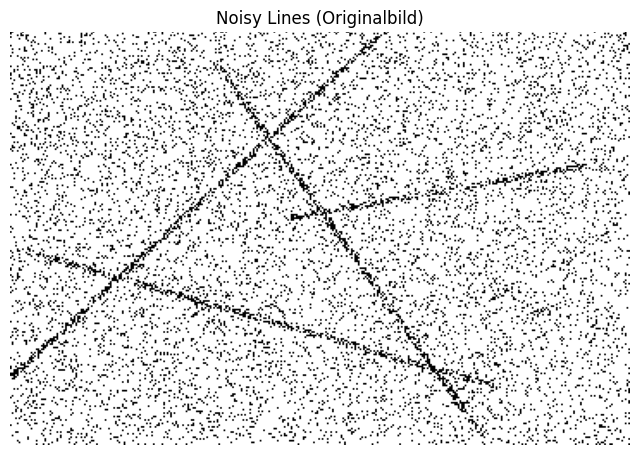

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.feature import canny
import os
from natsort import natsorted

# Bild einlesen
image = io.imread('noisy-lines.tif', as_gray=True)

# Bild korrekt als Graustufen anzeigen
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')  # cmap='gray' für korrekte Graustufenanzeige
plt.title("Noisy Lines (Originalbild)")
plt.axis('off')
plt.show()

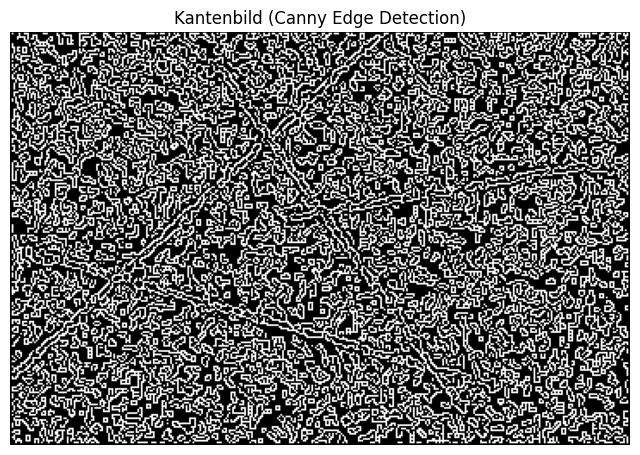

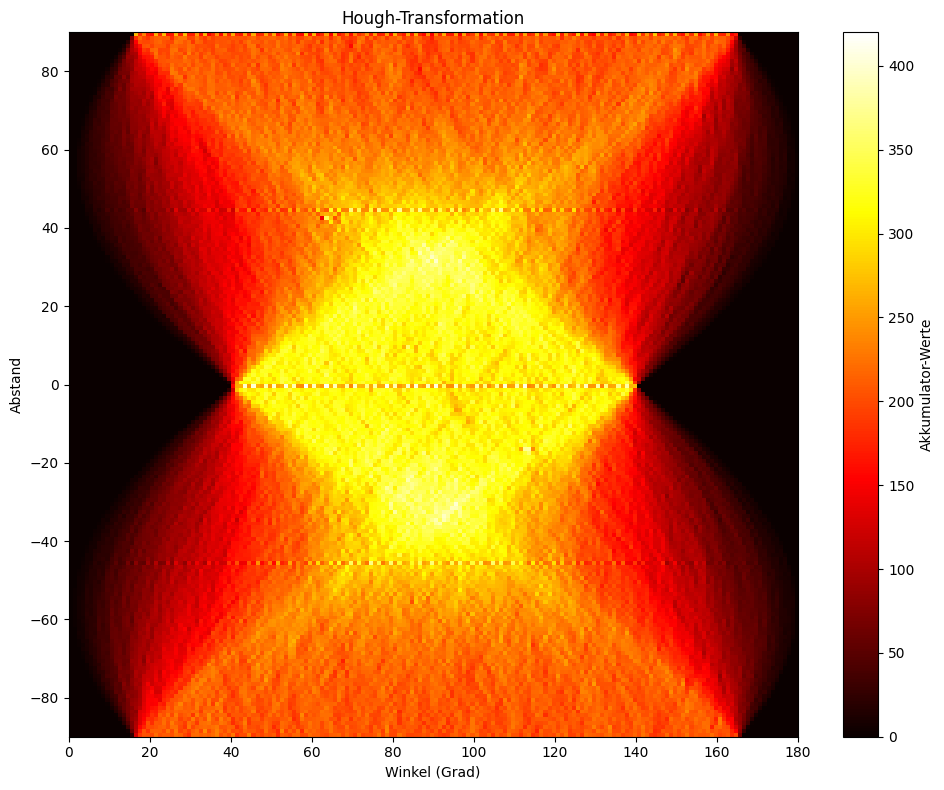

angels= [0.68067841 0.6981317  0.71558499 ... 2.46091425 2.47836754 2.47836754], distances=[ 20   9  -5 ...  26 -25   6]


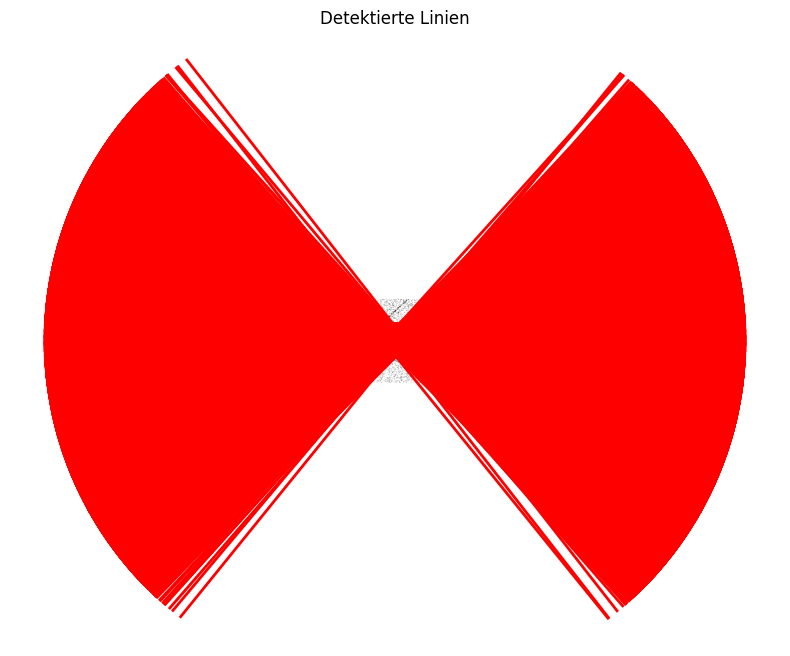

In [2]:
def linearHT(im_edge, angle_steps, radius_steps):
    height, width = im_edge.shape
    x_ctr, y_ctr = width // 2, height // 2
    
    # Schrittweiten berechnen
    d_ang = np.pi / angle_steps
    r_max = np.sqrt(x_ctr**2 + y_ctr**2)
    d_rad = (2 * r_max) / radius_steps
    
    # Hough-Akkumulator initialisieren
    hough_array = np.zeros((angle_steps, radius_steps), dtype=int)
    
    # Hough-Akkumulator füllen
    y_idxs, x_idxs = np.where(im_edge > 0)
    
    for i in range(len(y_idxs)):
        y, x = y_idxs[i], x_idxs[i]
        x_shifted = x - x_ctr
        y_shifted = y - y_ctr
        
        for a in range(angle_steps):
            theta = d_ang * a
            r = int(np.round((x_shifted * np.cos(theta) + y_shifted * np.sin(theta)) / d_rad) + radius_steps / 2)
            if 0 <= r < radius_steps:
                hough_array[a, r] += 1
    
    return hough_array

# Kantendetektion mit Canny-Algorithmus
edges = canny(image, sigma=1.0, low_threshold=0.1, high_threshold=0.2)

# Kanten anzeigen
plt.figure(figsize=(8, 8))
plt.imshow(edges, cmap='gray')
plt.title("Kantenbild (Canny Edge Detection)")
plt.axis('off')
plt.show()

# Hough-Transformation anwenden
hough_array = linearHT(edges, 180, 180)

# Hough-Raum anzeigen
plt.figure(figsize=(10, 8))
plt.imshow(hough_array, cmap='hot', aspect='auto', 
           extent=[0, 180, -90, 90])
plt.title("Hough-Transformation")
plt.xlabel("Winkel (Grad)")
plt.ylabel("Abstand")
plt.colorbar(label='Akkumulator-Werte')
plt.tight_layout()
plt.show()

# Linienparameter aus den Peaks im Hough-Raum finden
threshold = 0.7 * np.max(hough_array)  # 70% des Maximalwertes als Schwellwert
indices = np.where(hough_array >= threshold)

# Konvertiere Indizes zurück zu Winkel und Abstand
angles = indices[0] * (np.pi / 180)
distances = indices[1] - 180//2
print(f"angels= {angles}, distances={distances}")


# Detektierte Linien auf dem Originalbild zeichnen
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
plt.title("Detektierte Linien")
plt.axis('off')

height, width = image.shape
for angle, dist in zip(angles, distances):
    # Konvertiere von Hessescher Normalform zu Endpunktform
    a = np.cos(angle)
    b = np.sin(angle)
    x0 = a * dist + width // 2
    y0 = b * dist + height // 2
    
    # Berechne Endpunkte der Liniensegmente
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    
    # Zeichne die Linie
    plt.plot([x1, x2], [y1, y2], 'r-', linewidth=2)

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

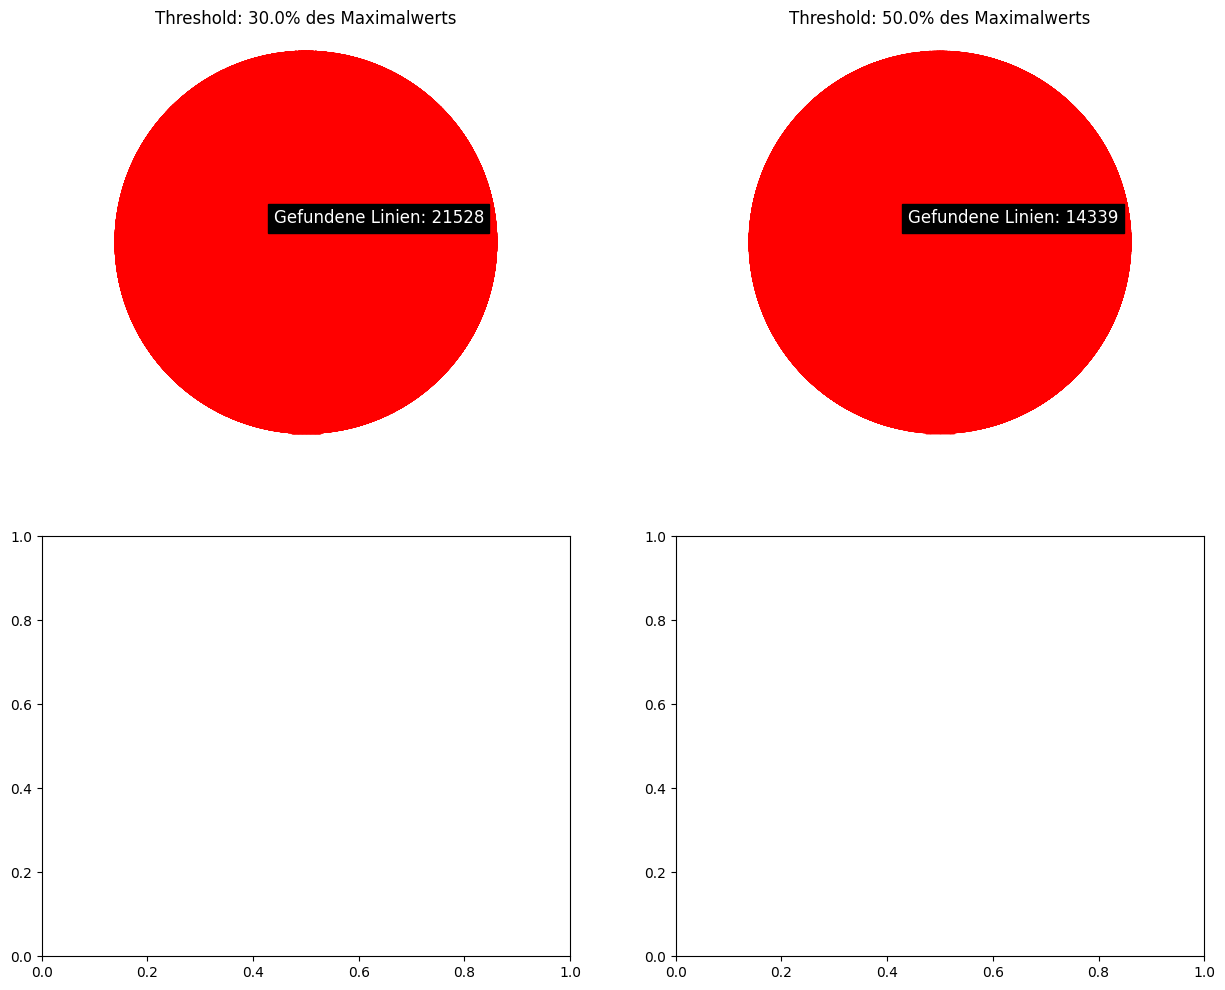

In [3]:
# Teil 3: Erweiterung mit Schwelloperation

def linearHT_with_threshold(im_edge, angle_steps, radius_steps, threshold_ratio=0.7):

    # Standard Hough-Transformation ausführen
    hough_array = linearHT(im_edge, angle_steps, radius_steps)
    
    # Schwelloperation durchführen
    max_value = np.max(hough_array)
    threshold = int(max_value * threshold_ratio)
    hough_thresholded = np.zeros_like(hough_array)
    hough_thresholded[hough_array >= threshold] = 1
    
    # Peaks identifizieren (Winkel und Radius der Linien)
    peak_indices = np.where(hough_array >= threshold)
    angles = peak_indices[0] * (np.pi / angle_steps)
    distances = peak_indices[1] - radius_steps // 2
    peak_params = list(zip(angles, distances))
    
    return hough_array, hough_thresholded, peak_params

# Verschiedene Schwellwerte testen und visualisieren
threshold_values = [0.3, 0.5, 0.7, 0.9]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, threshold_ratio in enumerate(threshold_values):
    # Anwenden der erweiterten Hough-Transformation mit Schwellwert
    _, hough_thresholded, peak_params = linearHT_with_threshold(edges, 180, 180, threshold_ratio)
    
    # Visualisierung der Linien auf dem Originalbild
    ax = axes[i]
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Threshold: {threshold_ratio*100}% des Maximalwerts")
    ax.axis('off')
    
    # Gefundene Linien zeichnen
    height, width = image.shape
    for angle, dist in peak_params:
        # Konvertiere von Hessescher Normalform zu Endpunktform
        a = np.cos(angle)
        b = np.sin(angle)
        x0 = a * dist + width // 2
        y0 = b * dist + height // 2
        
        # Berechne Endpunkte der Liniensegmente
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        
        # Zeichne die Linie
        ax.plot([x1, x2], [y1, y2], 'r-', linewidth=1)
    
    # Textinfo zur Anzahl der gefundenen Linien hinzufügen
    ax.text(10, 20, f"Gefundene Linien: {len(peak_params)}", 
            color='white', fontsize=12, backgroundcolor='black')

plt.tight_layout()
plt.show()

# Binäre Hough-Räume nach Schwelloperation anzeigen
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, threshold_ratio in enumerate(threshold_values):
    _, hough_thresholded, _ = linearHT_with_threshold(edges, 180, 180, threshold_ratio)
    
    axes[i].imshow(hough_thresholded, cmap='hot', aspect='auto', extent=[0, 180, -90, 90])
    axes[i].set_title(f"Binärer Hough-Raum (Threshold: {threshold_ratio*100}%)")
    axes[i].set_xlabel("Winkel (Grad)")
    axes[i].set_ylabel("Abstand")

plt.tight_layout()
plt.show()

# Bewertung der Schwellwerte
print("Bewertung der Schwellwerte:")
print("==========================")
for threshold_ratio in threshold_values:
    _, _, peak_params = linearHT_with_threshold(edges, 180, 180, threshold_ratio)
    print(f"Threshold {threshold_ratio*100}%: {len(peak_params)} Linien gefunden")
